In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import datetime
import os
from Imputer.knn_imputer import KNNImputer
import pdb
imagedir = 'images'
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)

# For numeric stability
EPSILON = 1e-10

df = pd.read_csv(
    'houselistings_simulated.csv', parse_dates=['ListingDate', 'SalesDate'])

dataset_end = df['SalesDate'].max()

FIRST_CUTOFF = pd.to_datetime('2017-09-01')
LAST_CUTOFF = df['SalesDate'].max() - pd.DateOffset(months=1)


def split_at(df, start_date=None, end_date=None):
    data_idx = np.ones(df.shape[0], dtype=bool)
    if start_date is not None:
        data_idx = data_idx & (df.SalesDate >= start_date)
    if end_date is not None:
        data_idx = data_idx & (df.ListingDate < end_date)
    return df.loc[data_idx, :].copy()


def scale(df, scaling_mean=None, scaling_std=None):
    numeric_features_train = df.select_dtypes(include=[np.number]).copy()
    if scaling_mean is None:
        scaling_mean, scaling_std = numeric_features_train.mean(
        ), numeric_features_train.std()
    numeric_features_train = (
        numeric_features_train - scaling_mean) / scaling_std
    return numeric_features_train, scaling_mean, scaling_std


def build_imputer(numeric_features_train):
    imputer = KNNImputer()
    imputer.fit(numeric_features_train)
    return imputer


def apply_imputer(imputer, features):
    features = features.copy()
    imputer.fill_in(features)
    return features


def build_Y(df, end):
    sold = df['SalesDate'] < end
    Y = df['SalesDate'].clip(upper=end).fillna(end) - df['ListingDate']
    return sold, Y.dt.days.astype(float)


class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes
        smoothing_factor = 1

        self.sold = tf.placeholder(tf.float32, shape=(None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))

        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(
                tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)

        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))[:,0]

        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) *
                               (1 - self.sold) + self.sold)

        def build_loss(loss, loss_indicator):
            loss_numerator = tf.reduce_sum(loss * self.loss_indicator)
            loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
            return loss_numerator / loss_denominator

        error_by_sample = (self.output - self.y)
        percent_error_by_sample = error_by_sample / (self.y + smoothing_factor)

        MSPE_raw = tf.reduce_mean(tf.square(percent_error_by_sample))
        MSE_raw = tf.reduce_mean(tf.square(error_by_sample))

        # Unused, but a demonstration of reasonable loss functions:
        self.MSPE = build_loss(MSPE_raw, self.loss_indicator)
        self.MSE = build_loss(MSE_raw, self.loss_indicator)

        # loss function used that takes into account both raw and percent loss
        MSPE_MSE_geometric_mean = tf.sqrt(MSPE_raw * MSE_raw)
        self.loss = build_loss(MSPE_MSE_geometric_mean, self.loss_indicator)

        MAPE_raw = tf.reduce_mean(tf.abs(percent_error_by_sample))
        self.MAPE = build_loss(MAPE_raw, self.loss_indicator)

        self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        self.trn_losses = []
        self.val_losses = []
        self.r2_scores = []

    def train_one_epoch(self, X_train, Y_train, sold_train, bs):
        # Train an epoch
        trn_loss = []
        # Randomly shuffle data and prepare for training
        trn_samples = X_train.shape[0]
        order = np.arange(trn_samples)
        np.random.shuffle(order)
        num_batches = (trn_samples // bs) + 1
        for itr in range(trn_samples // bs):
            rows = order[itr * bs:(itr + 1) * bs]
            if itr + 1 == num_batches:
                rows = order[itr * bs:]
            X_active, Y_active, Sold_active = [
                mat[rows] for mat in [X_train, Y_train, sold_train]
            ]
            feed_dict = {
                self.x: X_active,
                self.y: Y_active,
                self.sold: Sold_active
            }
            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict)
            trn_loss.append(loss)
        self.trn_losses.append(np.mean(trn_loss))

    def validate(self, X_test, Y_test, sold_test):
        feed_dict = {self.x: X_test, self.y: Y_test, self.sold: sold_test}
        val_loss, yhat = self.sess.run([self.loss, self.output], feed_dict)
        self.val_losses.append(val_loss)
        self.r2_scores.append(r2_score(Y_test, yhat))
        return yhat

    def train(self, Xtrn, Xval, Ytrn, Yval, Soldtrn, Soldval, epochs, bs=64):
        # Everything is set. Now train and validate
        for epoch in range(epochs):
            # run one epoch train and validation
            self.train_one_epoch(Xtrn, Ytrn, Soldtrn, bs)
            yhat = self.validate(Xval, Yval, Soldval)
        
            if (epoch % 10 == 0) or (epoch == epochs - 1):
                # Occasionally print to command line to inspect performance
                print('epoch:', epoch, 'train loss: ', self.trn_losses[-1],
                      'val loss: ', self.val_losses[-1], 'r2_score:',
                      self.r2_scores[-1])
        return yhat

    def visualize(self, name, fname=None):
        # Visualize training and validation losses and r2 scores on one plot
        _, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.trn_losses, label='train loss')
        ax1.plot(self.val_losses, label='test loss')
        ax2.plot(self.r2_scores, label='validation r2_scores', color='g')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('least square losses')
        ax2.set_ylabel('R2 Scores')
        ax2.legend()
        ax1.legend()
        plt.title('Losses and r2 scores for ' + name)
        if fname is not None:
            plt.savefig(imagedir + '/' + fname + '.jpg')
        plt.show()


def trn_validate(df, trn_end, val_end, layer_sizes):
    df_train = split_at(df, end_date=trn_end)
    df_val = split_at(df, start_date=trn_end, end_date=val_end)

    numeric_features_train, scaling_mean, scaling_std = scale(df_train)
    numeric_features_val, _, _ = scale(df_val, scaling_mean, scaling_std)
    nan_trn = numeric_features_train.isnull()
    nan_val = numeric_features_val.isnull()
    imputer = build_imputer(numeric_features_train)

    trn_imputed = apply_imputer(imputer, numeric_features_train)
    val_imputed = apply_imputer(imputer, numeric_features_val)

    trn_imputed = pd.concat((trn_imputed, nan_trn.astype(float)), 1)
    val_imputed = pd.concat((val_imputed, nan_val.astype(float)), 1)

    trn_sold, trn_Y = build_Y(df_train, trn_end)

    val_sold, val_Y = build_Y(df_val, dataset_end)

    n_features = trn_imputed.shape[1]

    model = Model(n_features, layer_sizes=layer_sizes)
    yhat = model.train(
        trn_imputed.values,
        val_imputed.values,
        trn_Y.values,
        val_Y.values,
        trn_sold.values,
        val_sold.values,
        epochs=100)
    model.visualize('Loss and r2_scores ' + str(trn_end)[:10] + ' to \n' +
                    str(val_end)[:10] + ' layers: ' + str(layer_sizes), str(trn_end)[:7] + ':' + str(val_end)[:7])
    return model.val_losses[-1], yhat, val_Y


def walkforward_optimization(df, FIRST_CUTOFF, LAST_CUTOFF):
    trn_end = FIRST_CUTOFF
    val_end = FIRST_CUTOFF + pd.DateOffset(months=1)
    validation_losses = pd.DataFrame()
    idx = 0
    yhat_all, val_Y_all = np.zeros(0), np.zeros(0)
    while val_end <= LAST_CUTOFF:
        idx += 1
        validation_loss, yhat, val_Y = trn_validate(df, trn_end, val_end, [100, 100])
        yhat_all = np.concatenate((yhat_all, yhat.flatten()), 0)
        val_Y_all = np.concatenate((val_Y_all, val_Y), 0)
        validation_losses.loc[idx, 'cutoffs'] = val_end
        validation_losses.loc[idx, 'losses'] = validation_loss
        trn_end = trn_end + pd.DateOffset(months=1)
        val_end = val_end + pd.DateOffset(months=1)
    return validation_losses, yhat_all, val_Y_all


def visualize_walkforward_optimization_performance(validation_losses):
    plt.plot(validation_losses['cutoffs'], validation_losses['losses'])
    plt.xticks(rotation=-60)
    plt.legend()
    plt.xlabel('cutoff time')
    plt.ylabel('validation loss')
    plt.title('losses throughout walkforward optimization')

    plt.savefig(imagedir + '/walkforward.jpg')
    plt.show()


epoch: 0 train loss:  117.04012 val loss:  78.79483 r2_score: -7.916800971550826
epoch: 10 train loss:  77.12606 val loss:  2.7389607 r2_score: 0.6925085623189472
epoch: 20 train loss:  76.23528 val loss:  2.4019885 r2_score: 0.7328009258882431
epoch: 30 train loss:  76.35898 val loss:  2.9113233 r2_score: 0.6886379862482384
epoch: 40 train loss:  77.2523 val loss:  2.9317605 r2_score: 0.6640428193678314
epoch: 50 train loss:  74.32993 val loss:  2.5238233 r2_score: 0.7284865004383121
epoch: 60 train loss:  75.12088 val loss:  3.396934 r2_score: 0.6334635447989913
epoch: 70 train loss:  73.56586 val loss:  3.125975 r2_score: 0.6504743266224704
epoch: 80 train loss:  76.28541 val loss:  3.9668915 r2_score: 0.5469645366696128
epoch: 90 train loss:  73.75644 val loss:  3.488067 r2_score: 0.6331369060023233
epoch: 99 train loss:  74.19672 val loss:  3.7347393 r2_score: 0.5873004106549895


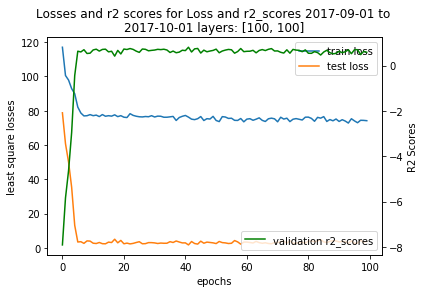

epoch: 0 train loss:  119.94571 val loss:  84.9717 r2_score: -8.239026156246485
epoch: 10 train loss:  84.25917 val loss:  3.7027903 r2_score: 0.6161034338396134
epoch: 20 train loss:  84.35183 val loss:  2.493381 r2_score: 0.7373595357536015
epoch: 30 train loss:  84.38417 val loss:  2.9502838 r2_score: 0.701286829313627
epoch: 40 train loss:  84.519394 val loss:  3.2666104 r2_score: 0.6577224185673023
epoch: 50 train loss:  83.18677 val loss:  2.725803 r2_score: 0.7360652185892987
epoch: 60 train loss:  80.19721 val loss:  2.796631 r2_score: 0.7020356646630582
epoch: 70 train loss:  82.15937 val loss:  2.6549509 r2_score: 0.7284534543355123
epoch: 80 train loss:  82.461914 val loss:  3.399233 r2_score: 0.6390824976146439
epoch: 90 train loss:  80.844 val loss:  2.7331135 r2_score: 0.7214208798596881
epoch: 99 train loss:  82.524445 val loss:  2.574069 r2_score: 0.7380287174072564


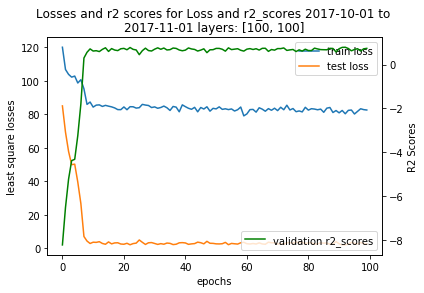

epoch: 0 train loss:  120.42231 val loss:  88.93229 r2_score: -8.909677239533696
epoch: 10 train loss:  81.40673 val loss:  2.9322498 r2_score: 0.685853766002627
epoch: 20 train loss:  81.65609 val loss:  3.0693777 r2_score: 0.649914675285602
epoch: 30 train loss:  79.967 val loss:  3.0567472 r2_score: 0.6489832869078506
epoch: 40 train loss:  78.43254 val loss:  3.11105 r2_score: 0.6627184649871435
epoch: 50 train loss:  82.20932 val loss:  2.1508012 r2_score: 0.7605022783713965
epoch: 60 train loss:  80.74443 val loss:  2.9842517 r2_score: 0.6883868177110535
epoch: 70 train loss:  77.22905 val loss:  2.8266716 r2_score: 0.6779874277969393
epoch: 80 train loss:  78.94449 val loss:  3.5616148 r2_score: 0.6040936633179538
epoch: 90 train loss:  77.71385 val loss:  2.5947518 r2_score: 0.7099003907395338
epoch: 99 train loss:  77.8588 val loss:  3.526748 r2_score: 0.5989880856873507


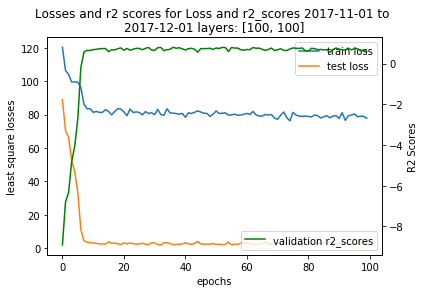

In [2]:
validation_losses, yhat_all, val_Y_all = walkforward_optimization(df, FIRST_CUTOFF, LAST_CUTOFF)

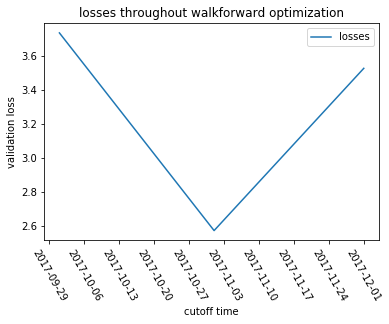

In [3]:
visualize_walkforward_optimization_performance(validation_losses)

In [11]:
def plot_by_group(yhat_all, val_Y_all, increment = 50):
    percent_error = np.abs((yhat_all - val_Y_all)/val_Y_all)
    true_bin = ((val_Y_all // increment) + 1) * increment
    err_bins = {}
    for pe, tb in zip(percent_error, true_bin):
        if not tb in err_bins.keys():
            err_bins[tb] = []
        err_bins[tb] += [pe * 100]

    err_list = [err_bins[key] for key in sorted(err_bins)]
    medians = [np.median(err_list[idx]) for idx in range(len(err_list))]
    q25s = [np.percentile(err_list[idx], 25) for idx in range(len(err_list))]
    q75s = [np.percentile(err_list[idx], 75) for idx in range(len(err_list))]
    keys = [key for key in sorted(err_bins)]
    _, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

    ax.set(
        xlabel='true time to sell house',
        ylabel='IQR of percent error by group',
        title="Percent Errors by house sales group")

    # Add std deviation bars to the previous plot
    ax.errorbar(
        keys,
        medians,
        yerr=[[medians[i] - q25s[i] for i in range(len(medians))],
              [q75s[i] - medians[i] for i in range(len(medians))]],
        fmt='-o')
    xticks = [
        str(key) + '\n' + str(len(err_list[idx]))
        for idx, key in enumerate(sorted(err_bins))
    ]
    ax.set_xlim([keys[0] - increment/2, keys[-1] + increment/2])
    ax.set_xticks(np.arange(np.min(keys), np.max(keys) + 1, increment))
    ax.set_xticklabels(xticks)
    plt.show()
    return err_bins

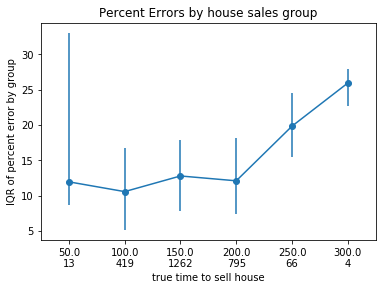

In [12]:
err_bins = plot_by_group(yhat_all, val_Y_all)